<a href="https://colab.research.google.com/github/stevejj4/Insurance-data-lifecycle/blob/main/Policies_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install google-cloud-bigquery
!pip install pyspark==3.1.2

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd
from pyspark.sql import SparkSession


In [41]:
# Authenticating and initializing BigQuery client
project_id = 'river-messenger-430112-e1'
client = bigquery.Client(project=project_id)

In [42]:
# Querying to get interactions table
query_policies = """
SELECT * FROM `river-messenger-430112-e1.Insurance_data.policies`;
"""

In [43]:
# Executing the query and converting to a pandas DataFrame
df_policies = client.query(query_policies).to_dataframe()

In [44]:
# Initializing SparkSession
spark = SparkSession.builder \
    .appName('BigQuerySparkApp') \
    .getOrCreate()

# Converting pandas DataFrame to Spark DataFrame
# Using iterrows() instead of iteritems() to iterate over DataFrame rows
spark_df_policies = spark.createDataFrame(df_policies.to_dict('records'))

# Show the schema and first few rows
spark_df_policies.printSchema()
spark_df_policies.show(5)

root
 |-- CustomerID: long (nullable = true)
 |-- PolicyEndDate: string (nullable = true)
 |-- PolicyID: long (nullable = true)
 |-- PolicyStartDate: string (nullable = true)
 |-- PolicyType: string (nullable = true)
 |-- PremiumAmount: double (nullable = true)

+----------+-------------+--------+---------------+----------+-------------+
|CustomerID|PolicyEndDate|PolicyID|PolicyStartDate|PolicyType|PremiumAmount|
+----------+-------------+--------+---------------+----------+-------------+
|         3|   2025-08-18|       3|     2023-07-07|      Auto|      3644.16|
|         9|   2024-09-12|       9|     2023-05-27|      Auto|      4010.11|
|        24|   2025-10-21|      24|     2023-10-04|      Auto|      3700.61|
|        27|   2027-04-21|      27|     2021-12-18|      Auto|      1838.51|
|        29|   2026-05-21|      29|     2023-09-01|      Auto|      1507.74|
+----------+-------------+--------+---------------+----------+-------------+
only showing top 5 rows



In [45]:
from pyspark.sql.functions import col, count, when, isnull, mean # Import the mean function

# Check for missing values in each column
spark_df_policies.select([count(when(isnull(c), c)).alias(c) for c in spark_df_policies.columns]).show()

# Handle missing values
# Example: Fill missing PremiumAmount with the average premium
mean_premium = spark_df_policies.select(mean(col("PremiumAmount"))).collect()[0][0]
spark_df_policies = spark_df_policies.fillna(mean_premium, subset=["PremiumAmount"])

# Check for inconsistencies
# Example: Check if PolicyEndDate is always after PolicyStartDate
inconsistent_dates = spark_df_policies.filter(col("PolicyEndDate") < col("PolicyStartDate"))
inconsistent_dates.show()

# Handle inconsistencies
# Example: Drop rows with inconsistent dates
spark_df_policies = spark_df_policies.filter(col("PolicyEndDate") >= col("PolicyStartDate"))

+----------+-------------+--------+---------------+----------+-------------+
|CustomerID|PolicyEndDate|PolicyID|PolicyStartDate|PolicyType|PremiumAmount|
+----------+-------------+--------+---------------+----------+-------------+
|         0|            0|       0|              0|         0|            0|
+----------+-------------+--------+---------------+----------+-------------+

+----------+-------------+--------+---------------+----------+-------------+
|CustomerID|PolicyEndDate|PolicyID|PolicyStartDate|PolicyType|PremiumAmount|
+----------+-------------+--------+---------------+----------+-------------+
+----------+-------------+--------+---------------+----------+-------------+



In [49]:
from pyspark.sql.functions import avg, datediff, to_date

# Calculate Policy Duration in days and create a new column
spark_df_policies = spark_df_policies.withColumn(
    "PolicyDuration",
    datediff(to_date(col("PolicyEndDate")), to_date(col("PolicyStartDate")))
)

# Create a new column 'DurationCategory' based on 'PolicyDuration'
spark_df_policies = spark_df_policies.withColumn(
    "DurationCategory",
    when(col("PolicyDuration") <= 365, "Short Term")
    .when((col("PolicyDuration") > 365) & (col("PolicyDuration") <= 730), "Medium Term")
    .otherwise("Long Term")
)

# Now you can calculate average PremiumAmount for each DurationCategory
avg_premiums = spark_df_policies.groupBy("DurationCategory").agg(avg("PremiumAmount").alias("AveragePremium"))

# Display the results
avg_premiums.show()
correlation = spark_df_policies.stat.corr("PremiumAmount", "PolicyDuration")
print(f"Correlation between PremiumAmount and PolicyDuration: {correlation}")

+----------------+------------------+
|DurationCategory|    AveragePremium|
+----------------+------------------+
|       Long Term|2988.0406402604453|
|     Medium Term|2998.5193333333345|
|      Short Term| 2999.230243902439|
+----------------+------------------+

Correlation between PremiumAmount and PolicyDuration: -0.01631009680957845


In [51]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import corr

# Encode DurationCategory as a numerical feature
indexer = StringIndexer(inputCol="DurationCategory", outputCol="DurationIndex")
spark_df_policies = indexer.fit(spark_df_policies).transform(spark_df_policies) # Uncomment this line to create the 'DurationIndex' column

# Calculate correlation between DurationIndex and PremiumAmount
correlation = spark_df_policies.select(corr("DurationIndex", "PremiumAmount")).collect()[0][0]

print(f"Correlation between DurationCategory and PremiumAmount: {correlation}")

Correlation between DurationCategory and PremiumAmount: 0.002386459884876911


In [52]:
spark_df_policies.show(5)

+----------+-------------+--------+---------------+----------+-------------+--------------+----------------+-------------+
|CustomerID|PolicyEndDate|PolicyID|PolicyStartDate|PolicyType|PremiumAmount|PolicyDuration|DurationCategory|DurationIndex|
+----------+-------------+--------+---------------+----------+-------------+--------------+----------------+-------------+
|         3|   2025-08-18|       3|     2023-07-07|      Auto|      3644.16|           773|       Long Term|          0.0|
|         9|   2024-09-12|       9|     2023-05-27|      Auto|      4010.11|           474|     Medium Term|          1.0|
|        24|   2025-10-21|      24|     2023-10-04|      Auto|      3700.61|           748|       Long Term|          0.0|
|        27|   2027-04-21|      27|     2021-12-18|      Auto|      1838.51|          1950|       Long Term|          0.0|
|        29|   2026-05-21|      29|     2023-09-01|      Auto|      1507.74|           993|       Long Term|          0.0|
+----------+----

+----------+-----+
|PolicyType|Count|
+----------+-----+
|    Health|  511|
|      Life|  500|
|      Home|  497|
|      Auto|  496|
+----------+-----+



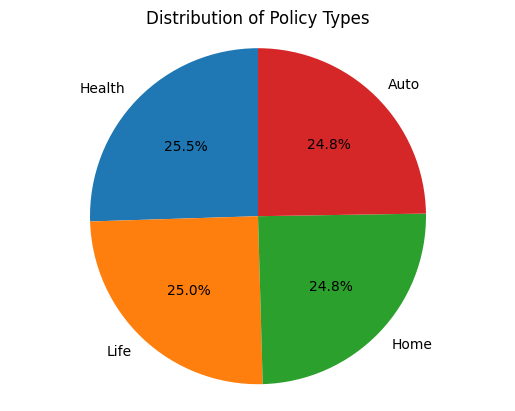

In [53]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import pandas as pd

# Count the occurrences of each policy type
policy_type_counts = spark_df_policies.groupBy("PolicyType").agg(count("*").alias("Count")).orderBy("Count", ascending=False)

# Display the results
policy_type_counts.show()

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pandas_df = policy_type_counts.toPandas()

# Create the pie chart
plt.pie(pandas_df['Count'], labels=pandas_df['PolicyType'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Policy Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [54]:
from pyspark.sql.functions import skewness, kurtosis

# Calculate skewness and kurtosis
skewness_value = spark_df_policies.select(skewness("PremiumAmount")).collect()[0][0]
kurtosis_value = spark_df_policies.select(kurtosis("PremiumAmount")).collect()[0][0]

print(f"Skewness: {skewness_value}")
print(f"Kurtosis: {kurtosis_value}")

Skewness: 0.02686222297438961
Kurtosis: -1.2099592718100038


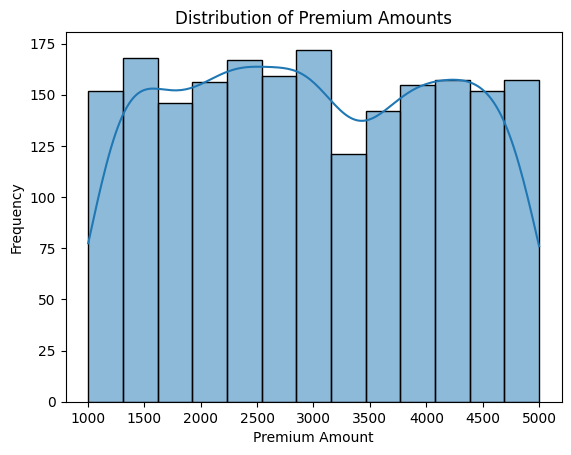

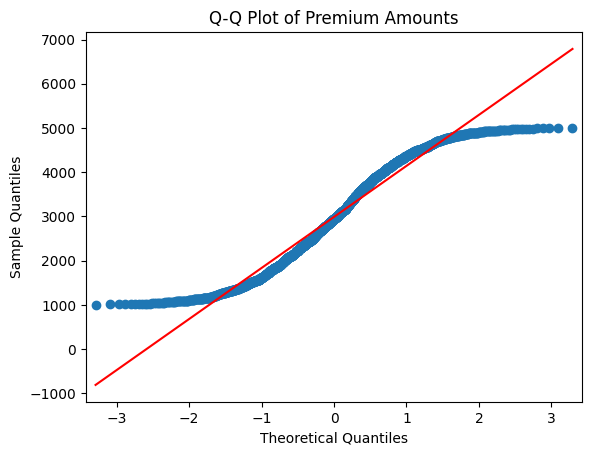

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pandas_df = spark_df_policies.select("PremiumAmount").toPandas()

# Create the histogram
sns.histplot(pandas_df['PremiumAmount'], kde=True)
plt.xlabel('Premium Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Premium Amounts')
plt.show()

# Create a Q-Q plot
import statsmodels.api as sm
sm.qqplot(pandas_df['PremiumAmount'], line='s')
plt.title('Q-Q Plot of Premium Amounts')
plt.show()

In [56]:
from pyspark.ml.feature import StringIndexer

# Create a StringIndexer object
indexer = StringIndexer(inputCol="PolicyType", outputCol="PolicyTypeIndex")

# Fit the indexer to the data and transform the DataFrame
spark_df_policies = indexer.fit(spark_df_policies).transform(spark_df_policies)

# Show the updated DataFrame
spark_df_policies.show(5)

+----------+-------------+--------+---------------+----------+-------------+--------------+----------------+-------------+---------------+
|CustomerID|PolicyEndDate|PolicyID|PolicyStartDate|PolicyType|PremiumAmount|PolicyDuration|DurationCategory|DurationIndex|PolicyTypeIndex|
+----------+-------------+--------+---------------+----------+-------------+--------------+----------------+-------------+---------------+
|         3|   2025-08-18|       3|     2023-07-07|      Auto|      3644.16|           773|       Long Term|          0.0|            3.0|
|         9|   2024-09-12|       9|     2023-05-27|      Auto|      4010.11|           474|     Medium Term|          1.0|            3.0|
|        24|   2025-10-21|      24|     2023-10-04|      Auto|      3700.61|           748|       Long Term|          0.0|            3.0|
|        27|   2027-04-21|      27|     2021-12-18|      Auto|      1838.51|          1950|       Long Term|          0.0|            3.0|
|        29|   2026-05-21| 

In [57]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = spark_df_policies.select("DurationIndex", "PolicyTypeIndex", "PremiumAmount").toPandas()

In [58]:
from google.cloud import bigquery

# Initialize BigQuery client
project_id = 'river-messenger-430112-e1'
client = bigquery.Client(project=project_id)

# Define the schema for your BigQuery table
schema = [
    bigquery.SchemaField("DurationIndex", "INTEGER"),
    bigquery.SchemaField("PolicyTypeIndex", "INTEGER"),
    bigquery.SchemaField("PremiumAmount", "FLOAT"),
    # Add other relevant columns and their data types
]

# Set the table ID (dataset.table_name)
dataset_id = 'Insurance_data'
# Construct the fully-qualified table ID
table_id = f"{project_id}.{dataset_id}.ML_team"

# Create the BigQuery table
table = bigquery.Table(table_id, schema=schema)
table = client.create_table(table)  # API request to create the table
print(f"Created table {table.project}.{table.dataset_id}.{table.table_id}")

# Load the pandas DataFrame into the BigQuery table
job_config = bigquery.LoadJobConfig(schema=schema)
job = client.load_table_from_dataframe(pandas_df, table_id, job_config=job_config)
job.result()  # Wait for the job to complete

print(f"Loaded {pandas_df.shape[0]} rows and {pandas_df.shape[1]} columns to {table_id}")

Created table river-messenger-430112-e1.Insurance_data.ML_team
Loaded 2004 rows and 3 columns to river-messenger-430112-e1.Insurance_data.ML_team


In [59]:


# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare features and target variable
X = pandas_df[["DurationIndex", "PolicyTypeIndex"]]
y = pandas_df["PremiumAmount"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1172.1435775272398


In [60]:
import numpy as np

# Define a tolerance threshold (e.g., 10% of the average premium)
tolerance = 0.1 * np.mean(y)

# Calculate absolute differences between predicted and actual values
errors = np.abs(y_test - y_pred)

# Count predictions within the tolerance
num_accurate = np.sum(errors <= tolerance)

# Calculate the percentage of accurate predictions
total_predictions = len(y_test)
accuracy_percentage = (num_accurate / total_predictions) * 100

print(f"Number of predictions within tolerance: {num_accurate}")
print(f"Percentage of accurate predictions: {accuracy_percentage:.2f}%")

Number of predictions within tolerance: 57
Percentage of accurate predictions: 14.21%


In [ ]:
# It seems like my model has a low accuracy of 14.21%. This indicates there's significant room for improvement.